In [17]:
import os
from dotenv import dotenv_values

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.optim import Adam
from torchmetrics import Accuracy

import nibabel as nib

from transformers import AutoFeatureExtractor, AutoModelForImageClassification

from PIL import Image

from transformers import ViTForImageClassification



Dataset: [BRaTS 2021 Task 1 Dataset](https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1)

Imaging Data Description
All BraTS mpMRI scans are available as NIfTI files (.nii.gz) and describe a) native (T1) and b) post-contrast T1-weighted (T1Gd), c) T2-weighted (T2), and d) T2 Fluid Attenuated Inversion Recovery (T2-FLAIR) volumes, and were acquired with different clinical protocols and various scanners from multiple data contributing institutions. We intend to release the associated de-identifed DICOM (.dcm) files after the conclusion of the challenge.

All the imaging datasets have been annotated manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edematous/invaded tissue (ED — label 2), and the necrotic tumor core (NCR — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The ground truth data were created after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm3) and skull-stripped.

### Variables globales

In [18]:
# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Defino la ruta de los datos de acuerdo. Seteado en el arhcivo ".env"
dataset_path = dotenv_values()['DATASETPATH']
print(dataset_path)

cuda
D:/Users/juanp_schamun/.cache/kagglehub/datasets/dschettler8845/brats-2021-task1/versions/1/BraTS2021_Training_Data


In [19]:
root_dir = dataset_path
patients = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
patients[:5]

['BraTS2021_00000',
 'BraTS2021_00002',
 'BraTS2021_00003',
 'BraTS2021_00005',
 'BraTS2021_00006']

In [20]:
tipos = ['t1', 't1ce', 't2', 'flair', 'seg']
tipos

['t1', 't1ce', 't2', 'flair', 'seg']

### Analisis exploratorio

shape: (240, 240)


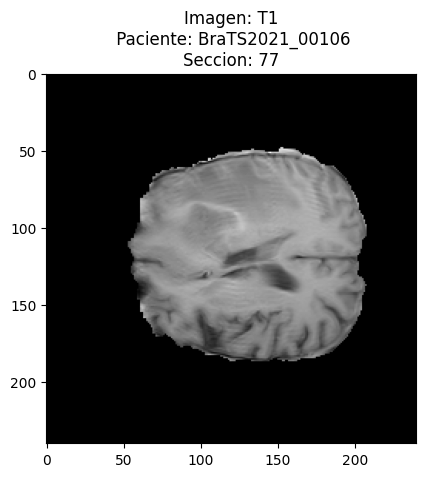

shape: (240, 240)


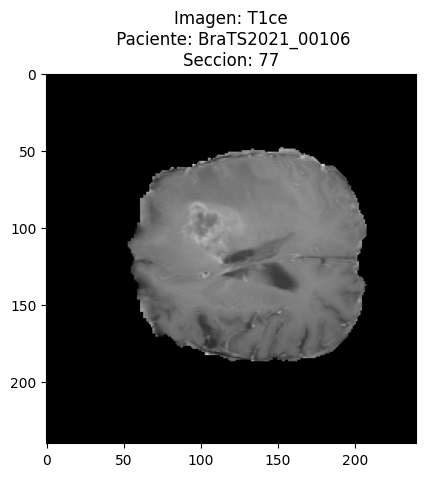

shape: (240, 240)


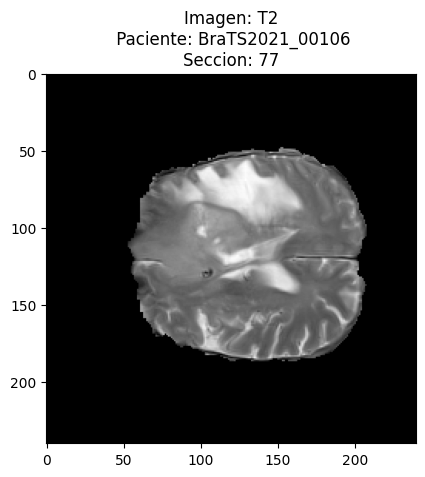

shape: (240, 240)


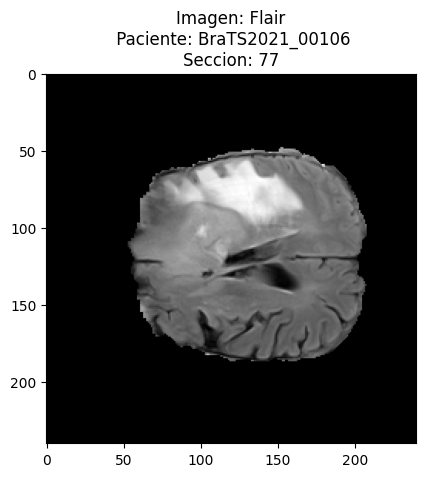

shape: (240, 240)


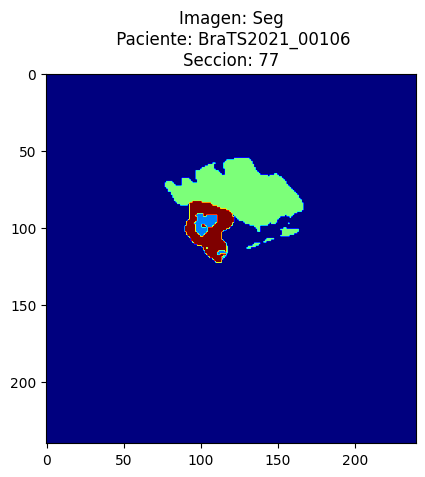

(5, 240, 240)

In [21]:
def mostrar_figura(indice: int=0, tipo: str='t1', seccion:int=77):

    '''
    Plotea la figura dependiendo indice del paciente y el tipo de imagen
    ------------------------------------------------------------
    inputs
    indice: el numero de acuerdo al orden de las carpetas
    tipo: tipo de figura {t1, t1ce, t2 flaiir, seg}
    '''
    
    # Cargar una imagen
    file = os.path.join(root_dir, patients[indice], f'{patients[indice]}_{tipo}.nii.gz')
    img = nib.load(file)

    # Obtener los datos de la imagen
    img_data = img.get_fdata()

    # Mostrar una sección de la imagen
    imagen = img_data[:, :, seccion]
    cm = 'jet' if tipo == 'seg' else 'gray'
    plt.imshow(imagen, cmap=cm)
    plt.title(f'Imagen: {str.capitalize(tipo)}\n Paciente: {patients[indice]}\nSeccion: {seccion}')    
    print
    print('shape:', imagen.shape)    
    plt.show()

    return imagen

# Ejemplo: muestro todos los tipos de imagenes de un paciente en la sección del medio

j = np.random.randint(156)

imagenes = []
for tipo in tipos:
    imagen = mostrar_figura(j, tipo)
    imagenes.append(imagen)
imagenes = np.array(imagenes)
imagenes.shape

In [57]:
def cargargz(indice: int=0, tipo: str='t1'):

    '''
    Carga la figura dependiendo indice del paciente y el tipo de imagen
    ------------------------------------------------------------
    inputs
    indice: el numero de acuerdo al orden de las carpetas
    tipo: tipo de figura {t1, t1ce, t2 flaiir, seg}
    '''
    
    # Cargar una imagen
    file = os.path.join(root_dir, patients[indice], f'{patients[indice]}_{tipo}.nii.gz')
    img = nib.load(file)

    # Obtener los datos de la imagen
    img_data = img.get_fdata()

    # Mostrar una sección de la imagen
    img_data = np.transpose(img_data,(2,0,1))
    # print('shape:', imagen.shape)
   

    return img

# tt = cargargz(0,'t1')
# tt.shape

In [ ]:
img = cargargz(0,'seg')
img

(240, 240, 155)

In [56]:
img

In [52]:
imagenes.shape

(5, 240, 240)

### 

In [10]:
# Clase dataset
class BrainTumorDataset(Dataset):

    '''
    Clase para manejar el dataset

    '''

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.masks = []

        # Obtener todos los subdirectorios de pacientes
        self.patients = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        

        for patient in self.patients:
            # Definir path de las imágenes
            t1_image = os.path.join(root_dir, patient, f'{patient}_t1.nii.gz')
            flair_image = os.path.join(root_dir, patient, f'{patient}_flair.nii.gz')
            seg_image = os.path.join(root_dir, patient, f'{patient}_seg.nii.gz')

            
            # Agregar las imágenes y las máscaras
            # voy a hacer un sólo tipo de imagen por ahora quito Flair *1
            # self.images.append((t1_image, flair_image))
            self.images.append(t1_image)
            self.masks.append(seg_image)

        assert len(self.images) == len(self.masks), "There must be as many images as there are masks"

          
    def __len__(self):
        return len(self.images*155)

    # Función para cargar las imágenes
    def load_image(self, image_path):
        img = nib.load(image_path)
        img_data = img.get_fdata()
        img_data = np.transpose(img_data,(2,0,1))
        return img_data

    def __getitem__(self, idx):

        idx_ent = idx // 155
        idx_resto = idx % 155

        # t1_path, flair_path = self.images[idx_ent]
        t1_path = self.images[idx_ent]
        seg_path = self.masks[idx_ent]
        # Cargar las imágenes
        t1_img = self.load_image(t1_path)
        # flair_img = self.load_image(flair_path) # *1
        seg_img = self.load_image(seg_path)

        t1_img_sec = t1_img[idx_resto]        
        # flair_img_sec = flair_img[idx_resto] # *1
        seg_img_sec = seg_img[idx_resto]                       

        # Convertir a un formato adecuado para ViT
        t1_img_sec = np.expand_dims(t1_img_sec, axis=0) # *1

        # flair_img_sec = np.expand_dims(flair_img_sec, axis=0) # *1

        combined_img_sec = np.concatenate((t1_img_sec, t1_img_sec, t1_img_sec), axis=0)  # Concatenamos las imágenes (2 canales)
        combined_img_sec = np.transpose(combined_img_sec, (1, 2, 0)) # Trasnpongo el canal, para que coincida con el formato que se espera
        
        
        # Aplicar transformaciones si es necesario
        if self.transform:
            combined_img_sec = self.transform(combined_img_sec)
            
        return combined_img_sec, seg_img_sec

dataset = BrainTumorDataset(root_dir=dataset_path)


In [11]:
# Transformaciones para ViT
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Tamaño de entrada para ViT
    # transforms.ToTensor(),
])

dataset = BrainTumorDataset(root_dir=dataset_path)
dataset2 = BrainTumorDataset(root_dir=dataset_path, transform=transform)
print(type(dataset[0][0]), dataset[0][0].shape)
print(type(dataset2[0][0]),dataset2[0][0].shape)
print(len(dataset))



<class 'numpy.ndarray'> (240, 240, 3)
<class 'torch.Tensor'> torch.Size([3, 224, 224])
193905


In [15]:
dataset2[0][0].shape

torch.Size([3, 224, 224])